In [14]:
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.base import ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neural_network import MLPClassifier

# new helpers:
from shared import dataset_local_path, bootstrap_accuracy, simple_boxplot, TODO

# stdlib:
from dataclasses import dataclass
import json
from typing import Dict, Any, List

In [15]:
examples = []
ys = []

with open(dataset_local_path("poetry_id.jsonl")) as fp:
    for line in fp:
        info = json.loads(line)
        # Note: the data contains a whole bunch of extra stuff; we just want numeric features for now.
        keep = info["features"]
        # whether or not it's poetry is our label.
        ys.append(info["poetry"])
        # hold onto this single dictionary.
        examples.append(keep)

## CONVERT TO MATRIX:

feature_numbering = DictVectorizer(sort=True)
X = feature_numbering.fit_transform(examples)

print("Features as {} matrix.".format(X.shape))


## SPLIT DATA:

RANDOM_SEED = 12345678

# Numpy-arrays are more useful than python's lists.
y = np.array(ys)
# split off train/validate (tv) pieces.
X_tv, X_test, y_tv, y_test = train_test_split(
    X, y, train_size=0.75, shuffle=True, random_state=RANDOM_SEED
)
# split off train, validate from (tv) pieces.
X_train, X_vali, y_train, y_vali = train_test_split(
    X_tv, y_tv, train_size=0.66, shuffle=True, random_state=RANDOM_SEED
)

print(X_train.shape, X_vali.shape, X_test.shape)


Features as (2772, 38) matrix.
(1372, 38) (707, 38) (693, 38)


In [16]:
@dataclass
class ExperimentResult:
    vali_acc: float
    params: Dict[str, Any]
    model: ClassifierMixin


In [17]:
def consider_decision_trees():
    print("Consider Decision Tree.")
    performances: List[ExperimentResult] = []
    for rnd in range(3):
        for crit in ["entropy", "gini"]:
            for d in range(1, 9):
                params = {
                    "criterion": crit,
                    "max_depth": d,
                    "random_state": rnd,
                }
                f = DecisionTreeClassifier(**params)
                f.fit(X_train, y_train)
                vali_acc = f.score(X_vali, y_vali)
                result = ExperimentResult(vali_acc, params, f)
                performances.append(result)
    return max(performances, key=lambda result: result.vali_acc)


def consider_random_forest():
    print("Consider Random Forest.")
    performances: List[ExperimentResult] = []
    # Random Forest
    for rnd in range(3):
        for crit in ["entropy","gini"]:
            for d in range(4, 9):
                params = {
                    "criterion": crit,
                    "max_depth": d,
                    "random_state": rnd,
                }
                f = RandomForestClassifier(**params)
                f.fit(X_train, y_train)
                vali_acc = f.score(X_vali, y_vali)
                result = ExperimentResult(vali_acc, params, f)
                performances.append(result)
    return max(performances, key=lambda result: result.vali_acc)


def consider_perceptron() -> ExperimentResult:
    print("Consider Perceptron.")
    performances: List[ExperimentResult] = []
    for rnd in range(3):
        for max_iter in range(100,2000,100):
            params = {
                "random_state": rnd,
                "penalty": None,
                "max_iter": max_iter,
            }
            f = Perceptron(**params)
            f.fit(X_train, y_train)
            vali_acc = f.score(X_vali, y_vali)
            result = ExperimentResult(vali_acc, params, f)
            performances.append(result)

    return max(performances, key=lambda result: result.vali_acc)


def consider_logistic_regression() -> ExperimentResult:
    print("Consider Logistic Regression.")
    performances: List[ExperimentResult] = []
    for rnd in range(3):
        for max_iter in range(100,2000,100):
            for c in range(1,3,1):
                for pen in ['l1', 'l2']:
                    params = {
                        "random_state": rnd,
                        "penalty": pen,
                        "max_iter": 100,
                        "C": c,
                    }
                    f = LogisticRegression(**params)
                    f.fit(X_train, y_train)
                    vali_acc = f.score(X_vali, y_vali)
                    result = ExperimentResult(vali_acc, params, f)
                    performances.append(result)

    return max(performances, key=lambda result: result.vali_acc)


def consider_neural_net() -> ExperimentResult:
    print("Consider Multi-Layer Perceptron.")
    performances: List[ExperimentResult] = []
    for rnd in range(3):
        for l_sizes in [(18,),(20,),(22,),(24,),(26,),(28,),(30,),(32,)]:
            for max_iter in range(7000,10000,1000):
                for optim in ['lbfgs', 'sgd', 'adam']:
                    for activation in ['identity', 'logistic', 'tanh', 'relu']:
                        params = {
                            "hidden_layer_sizes": l_sizes,
                            "random_state": rnd,
                            "solver": optim,
                            "max_iter": max_iter,
                            "activation":activation,
                            "alpha": 0.0001,
                        }
                        f = MLPClassifier(**params)
                        f.fit(X_train, y_train)
                        vali_acc = f.score(X_vali, y_vali)
                        result = ExperimentResult(vali_acc, params, f)
                        performances.append(result)

    return max(performances, key=lambda result: result.vali_acc)


logit = consider_logistic_regression()
perceptron = consider_perceptron()
dtree = consider_decision_trees()
rforest = consider_random_forest()
mlp = consider_neural_net()

print("Best Logistic Regression", logit)
print("Best Perceptron", perceptron)
print("Best DTree", dtree)
print("Best RForest", rforest)
print("Best MLP", mlp)

Consider Logistic Regression.


/Users/Alderik/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Consider Perceptron.
Consider Decision Tree.
Consider Random Forest.


/Users/Alderik/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Alderik/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Alderik/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Alderik/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Alderik/anaconda3/lib/python3

Consider Multi-Layer Perceptron.
Best Logistic Regression ExperimentResult(vali_acc=0.942008486562942, params={'random_state': 0, 'penalty': 'l1', 'max_iter': 100, 'C': 2}, model=LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False))
Best Perceptron ExperimentResult(vali_acc=0.9038189533239038, params={'random_state': 0, 'penalty': None, 'max_iter': 100}, model=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=100, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False))
Best DTree ExperimentResult(vali_acc=0.9335219236209336, params={'criterion': 'entro

### 1. Understand consider_decision_trees; I have 'tuned' it.

tuning by trying many combinations of criterion random states and depths. 

In [ ]:
def consider_decision_trees():
    print("Consider Decision Tree.")
    performances: List[ExperimentResult] = []
    for rnd in range(3): #LOOP THREE DIFFERENT RANDOM STATES
        for crit in ["entropy", "gini"]: #LOOP THROUGH CRITERION
            for d in range(1, 9): #LOOP THORUGH DEPTHS
                params = {
                    "criterion": crit,
                    "max_depth": d,
                    "random_state": rnd,
                }
                f = DecisionTreeClassifier(**params)
                f.fit(X_train, y_train)
                vali_acc = f.score(X_vali, y_vali)
                result = ExperimentResult(vali_acc, params, f)
                performances.append(result)
    return max(performances, key=lambda result: result.vali_acc)

### 2. Find appropriate max_iter settings to stop warning messages.

it took the max_iter to get to be greater than 7000 to get no convergence warnings

### 3. Pick a model: {perceptron, logistic regression, neural_network} and optimize it!

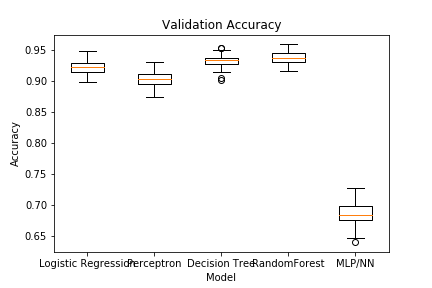

In [18]:

from IPython.display import Image
Image(filename='model-cmp.png') 
#PRE-PARAMETER TUNING

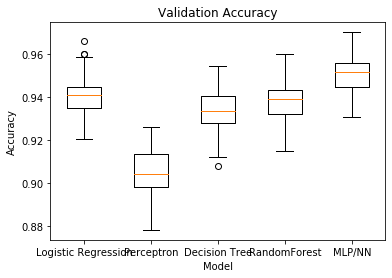

<module 'matplotlib.pyplot' from '/Users/Alderik/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [19]:
%matplotlib inline

# Helper method to make a series of box-plots from a dictionary:
simple_boxplot(
    {
        "Logistic Regression": bootstrap_accuracy(logit.model, X_vali, y_vali),
        "Perceptron": bootstrap_accuracy(perceptron.model, X_vali, y_vali),
        "Decision Tree": bootstrap_accuracy(dtree.model, X_vali, y_vali),
        "RandomForest": bootstrap_accuracy(rforest.model, X_vali, y_vali),
        "MLP/NN": bootstrap_accuracy(mlp.model, X_vali, y_vali),
    },
    title="Validation Accuracy",
    xlabel="Model",
    ylabel="Accuracy",
    save="model-cmp2.png",
)